In [118]:
import xml.etree.ElementTree as ET

def get_calibration(img_file):
    namespaces = {'leica': 'http://www.leica.com'}
    tree = ET.parse(img_file + '.anx')
    dx_basic_annotation_settings = tree.getroot()

    # Get image size metadata
    image_size_elm = dx_basic_annotation_settings.find('leica:ImageSize', namespaces)
    width = int(image_size_elm.find('leica:Width', namespaces).text)
    height = int(image_size_elm.find('leica:Height', namespaces).text)

    center_width = width / 2
    center_height = height / 2

    # Get image calibration metadata
    calibration = dx_basic_annotation_settings.find('leica:Calibration', namespaces)
    metres_per_pixel_elm = calibration.find('leica:MetresPerPixel', namespaces)
    metres_per_pixel = float(metres_per_pixel_elm.text)
    µm_per_pixel = metres_per_pixel * 1_000_000
    unit_per_pixel = metres_per_pixel * 10_000
    
    return {
        'metres_per_pixel': metres_per_pixel,
        'center_width': center_width,
        'center_height': center_height,
        'µm_per_pixel': µm_per_pixel,
        'unit_per_pixel': unit_per_pixel,
    }

In [119]:
# Get nematocyst locations

def get_points(img_file, calibration):
    tree = ET.parse(img_file + '.lmd')
    lm_data_store = tree.getroot()
    xml_points = lm_data_store.find('LMDataEntity').findall('LMMeasurementItemPoints')
    points = list(map(lambda point: {
        'raw_x_offset': float(point.find('PositionX').text),
        'raw_y_offset': float(point.find('PositionY').text),
        'index': int(point.find('PointIndex').text),
        'id': point.find('ItemId').text,
    }, xml_points))
    
    points = [p for p in points if p['index'] != 2]

    unit_per_pixel = calibration['unit_per_pixel']
    
    # arbitrary translation factors
    x_cal = 0
    y_cal = 0

    for point in points:
        point['x'] = (point['raw_x_offset'] * unit_per_pixel) + calibration['center_width'] + x_cal
        point['y'] = (point['raw_y_offset'] * unit_per_pixel) + calibration['center_height'] + y_cal
    
    return points

In [120]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def plt_box(img_file, points):
    fig = plt.figure(figsize=(15, 15))
    img = mpimg.imread(img_file)
    min_X = min(p['x'] for p in points)
    max_X = max(p['x'] for p in points)
    min_Y = min(p['y'] for p in points)
    max_Y = max(p['y'] for p in points)
    max_diff = max([max_X - min_X, max_Y - min_Y]);
    X_centre = min_X + (max_X - min_X)/2
    Y_centre = min_Y + (max_Y - min_Y)/2
    
    min_Y = Y_centre - (1.5*max_diff/2)
    max_Y = Y_centre + (1.5*max_diff/2)
    min_X = X_centre - (1.5*max_diff/2)
    max_X = X_centre + (1.5*max_diff/2)

    xyz = img[int(min_Y):int(max_Y),int(min_X):int(max_X), :]
    plt.imshow(xyz)
    plt.savefig('image0010_cropped.png')
    plt.show()

In [121]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def plt_image(img_flie, points):
    fig = plt.figure(figsize=(15, 15))
    img = mpimg.imread(img_file)
    plt.imshow(img)
    plt.plot([p['x'] for p in points], [p['y'] for p in points], 'ro')
    plt.savefig('image0010_point.png')

In [122]:
# Orient all pictures to get the length of the capsule horizontal to the x-axis 
import scipy
from scipy import ndimage
import math

def orient_capsule(img_file, points):
    min_X = min(p['x'] for p in points)
    max_X = max(p['x'] for p in points)
    min_Y = min(p['y'] for p in points)
    max_Y = max(p['y'] for p in points)
    tan = (max_Y-min_Y)/(max_X-min_X)
    angle = math.atan(tan)
    
    fig = plt.figure(figsize=(15, 15))
    img = mpimg.imread(img_file)
    rotated_img = scipy.ndimage.rotate(img, 360 - angle*57.2958)
    plt.imshow(rotated_img)
    plt.savefig('image0010_rotated.png')
    plt.show()
    

In [123]:
# Calculate Length and width of nematocyst
import math

def print_info(calibration, points):
    dist = [None] * 7
    for i in range(len(points)):
        for j in range(len(points)):
            dist[i+j] = math.sqrt(math.pow((points[i]['x']-points[j]['x']),2) + math.pow((points[i]['y']-points[j]['y']),2))
    
    metres_per_pixel = calibration['metres_per_pixel']
    print ("Width: ", min(d for d in dist if d > 0)*metres_per_pixel, " meters")
    print ("Length: ", max(dist)*metres_per_pixel, " meters")
    

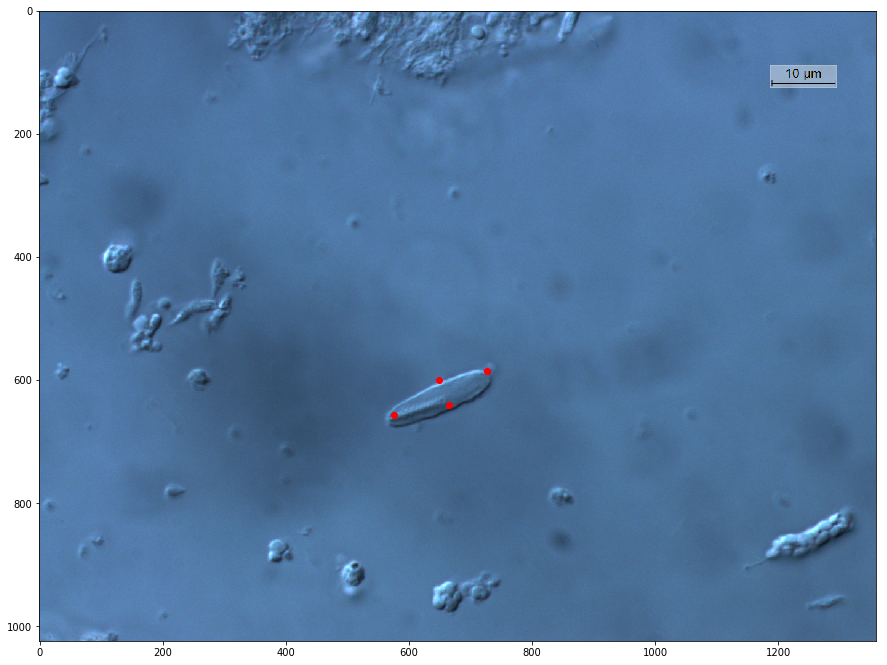

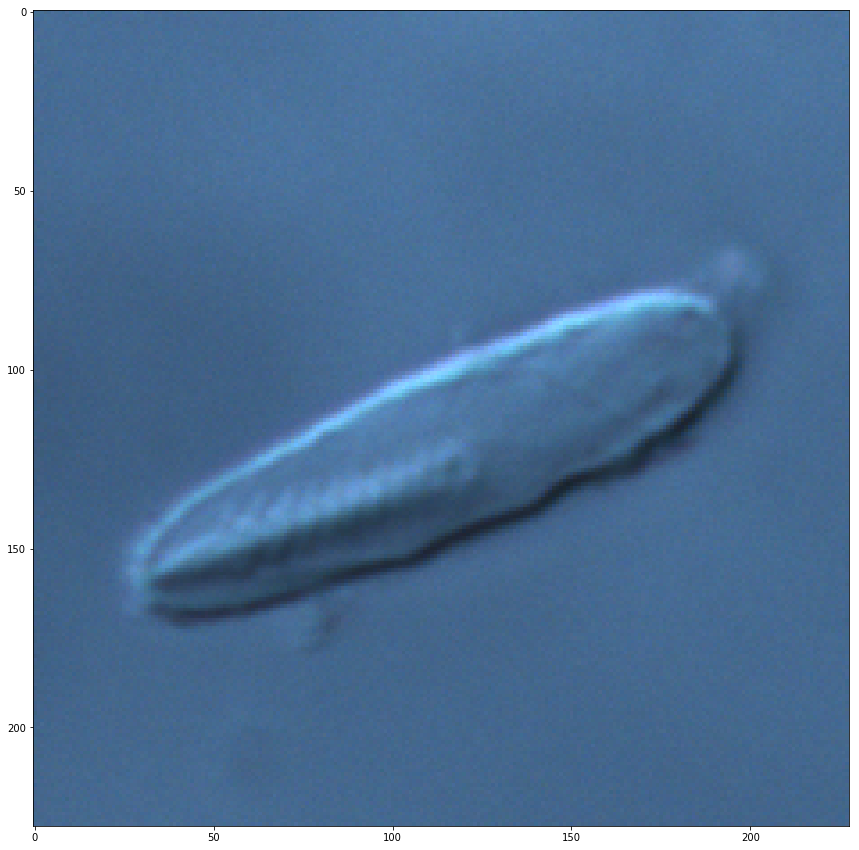

Width:  3.975794688177635e-06  meters
Length:  1.5521592589942648e-05  meters


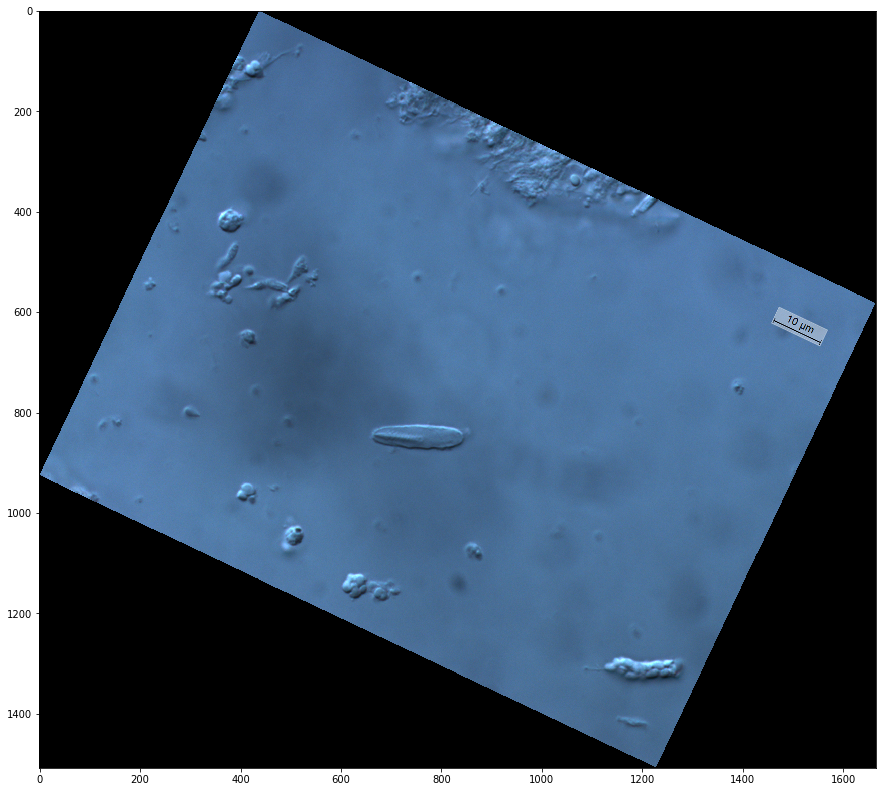

In [117]:
import os
#%matplotlib inline

p_base = 'Intermediates-Help/' + '1st problem/'
p_new = p_base + 'Diakanemes'
p_A = p_base + 'pA/Anthopleura_MEX13' 

f_A = []
for root, dirs, files in os.walk(p_A):
    for file in files:
        if file.endswith("tif"):
             f_A.append(os.path.join(root, file))

#for img_file in files:
#img_file = 'Intermediates-Help/1st problem/pA/Anthopleura_MEX15/filament/image0030.tif'
img_file = f_A[0]
calibration = get_calibration(img_file)
points = get_points(img_file, calibration)    
plt_image(img_file, points)
plt_box(img_file, points)
print_info(calibration, points)
orient_capsule(img_file, points)